In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2023-07-08 10:29:12.224206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-08 10:29:14.072805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-08 10:29:14.077662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-08 10:29:14.078010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
pd.set_option("display.max_rows", 15)

## The Dataset

Similar to former notebooks where we worked with the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315), where here have a smaller X-ray dataset containing 5856 images.
Instead of 14 different diseases we will here concentrate on much fewer possible labels so that *hopefully* the number of images is enough to train good deep learning classifiers.

The images are distributed accross two folders (`NORMAL` and `PNEUMONIA`), the related metadata can be found in `x_ray_metadata_portfolio.csv` but actually also is reflected in the image file names.

## Import metadata

In [4]:
path = "shared_folder/data/ChestXray_pneumonia_prediction/"
csv_file = 'x_ray_metadata_portfolio.csv'
metadata = pd.read_csv(path + csv_file)

# Portfolio exercises:

### 1. load and inspect the data 
- what are missing/problematic entries?

In [5]:
metadata.head()

,patient_id,label,infection_type,folder,image
0,0001,normal,none,NORMAL,IM-0001-0001.jpeg
1,0003,normal,none,NORMAL,IM-0003-0001.jpeg
2,0005,normal,none,NORMAL,IM-0005-0001.jpeg
3,0006,normal,none,NORMAL,IM-0006-0001.jpeg
4,0007,normal,none,NORMAL,IM-0007-0001.jpeg


In [6]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   patient_id      5856 non-null   object
 1   label           5856 non-null   object
 2   infection_type  5856 non-null   object
 3   folder          5856 non-null   object
 4   image           5856 non-null   object
dtypes: object(5)
memory usage: 228.9+ KB


In [48]:
metadata.describe()

,label,none,virus,bacteria
count,5856.000000,5856.000000,5856.000000,5856.000000
mean,0.729679,0.270321,0.254952,0.474727
std,0.444164,0.444164,0.435872,0.499403
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [7]:
metadata.isnull().sum()

patient_id        0
label             0
infection_type    0
folder            0
image             0
dtype: int64

There are no null values in our data and we can use it without deleting or filling any entries. 5856 entries are a good amount of data to work with, although more data is always better and the data might still be unbalanced. This is inspected in the next step.

##### inspect some images

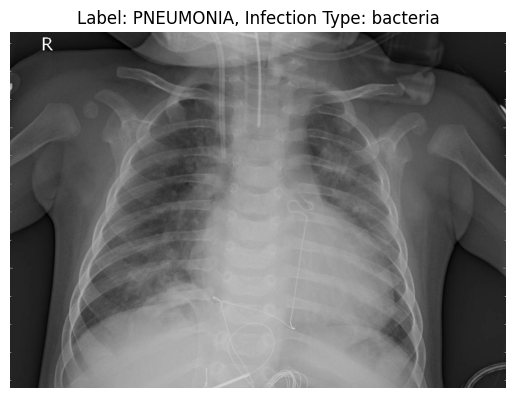

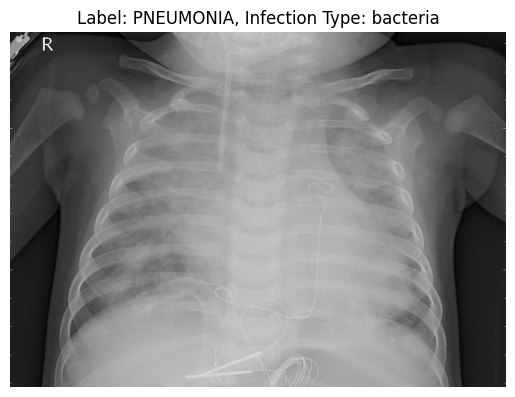

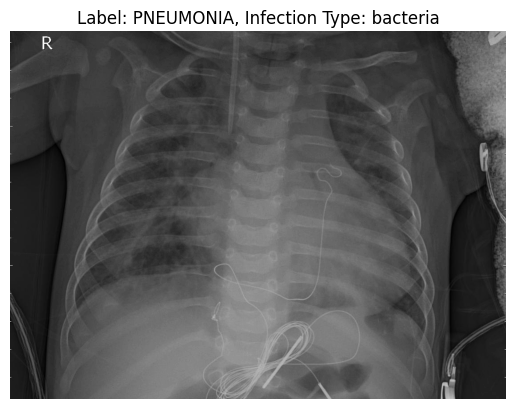

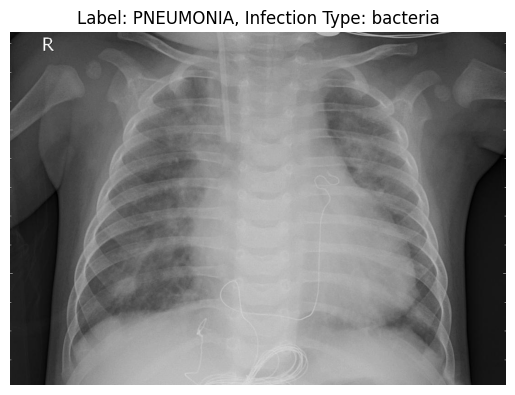

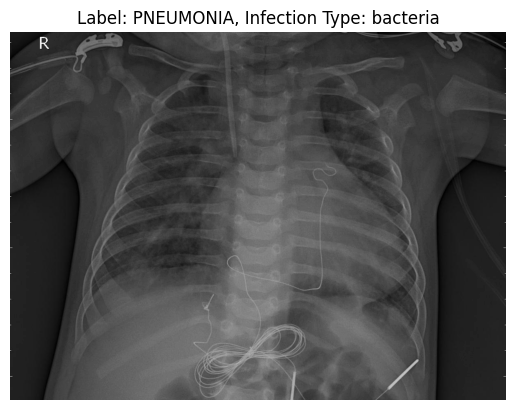

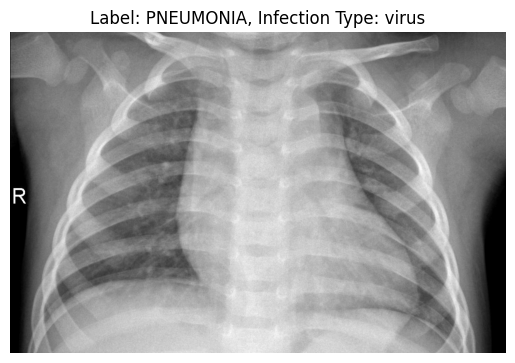

In [56]:
from PIL import Image

target_patient_id = 'person448'

# only rows concerning the selected patient
target_rows = metadata[metadata['patient_id'] == target_patient_id]
target_rows

# plot the selected target_patient_id with the label

# Iterate over each row and plot the images with label
for i, row in target_rows.iterrows():
    image_path = path + '/' + row['folder'] + '/' + row['image']
    image = Image.open(image_path)

    # Get the label of the image
    folder_label = row['folder']
    infection_label = row['infection_type']

    # Plot the image with labels
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {folder_label}, Infection Type: {infection_label}")
    plt.axis('off')
    plt.show()

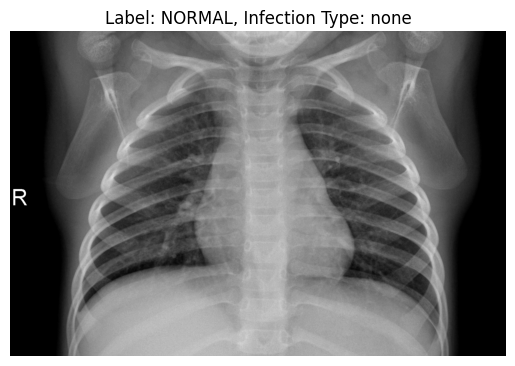

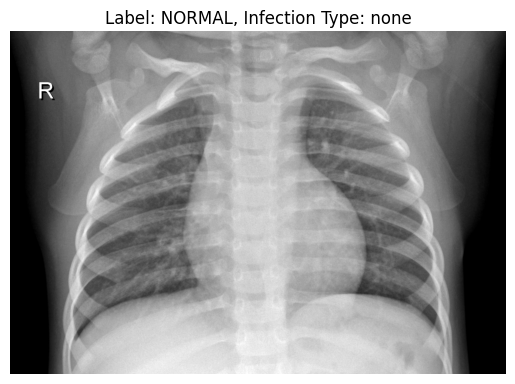

In [57]:
from PIL import Image

target_patient_id = '0448'

# only rows concerning the selected patient
target_rows = metadata[metadata['patient_id'] == target_patient_id]
target_rows

# plot the selected target_patient_id with the label

# Iterate over each row and plot the images with label
for i, row in target_rows.iterrows():
    image_path = path + '/' + row['folder'] + '/' + row['image']
    image = Image.open(image_path)

    # Get the label of the image
    folder_label = row['folder']
    infection_label = row['infection_type']

    # Plot the image with labels
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {folder_label}, Infection Type: {infection_label}")
    plt.axis('off')
    plt.show()

### 2. data exploration and cleaning 
- remove, fill, change data (if you think this makes sense or is necessary/beneficial)
- inspect two different types of labels (`label` and `infection_type`). How many classes are there and is there any bias? If so, is there anything we have to take care of?

In [8]:
metadata['infection_type'].value_counts()

infection_type
bacteria    2780
none        1583
virus       1493
Name: count, dtype: int64

In [9]:
metadata['label'].value_counts()

label
pneumonia    4273
normal       1583
Name: count, dtype: int64

In [10]:
metadata.loc[metadata['label'] == 'pneumonia'].__len__() / metadata.loc[metadata['label'] == 'normal'].__len__()

2.6993051168667086

There are 3 infection types: bacteria, virus and none. There are roughly as many viral infections as there are healthy patients (infection_type = none). But the amount of bacterial infections is almost double the size of the other two cases.  
The 'label' column of the dataset is heavily biased towards the patients with pneumonia. There are 2.7 times as much patients with pneumonia, than there are patients without pneumonia.

In [11]:
counter = 0
tagged_and_dieseased_counter = 0
untagged_and_healthy_counter = 0

for index, row in metadata.iterrows():
    # check if all infected are also diseased
    if(row["infection_type"] == "none" and row['label'] == 'pneumonia'):
         counter+=1
         
    # check those weird ids
    if('person' in row['patient_id'] and row['label'] == 'pneumonia'):
        tagged_and_dieseased_counter +=1
    elif('person' not in row['patient_id'] and row['label'] == 'normal'):
        untagged_and_healthy_counter +=1
    else:
        print('Patient ID {} does not fit in either of these cases!'.format(row['patient_id']))
         
print("There are {} patients with pneumonia, that have no bacterial or viral infection".format(counter))
print()
print('{} % of patients with pneumonia have the tag \'person\' in their patient_id.'.format(tagged_and_dieseased_counter/len(metadata.loc[metadata['label'] == 'pneumonia']) * 100))
print('{} % of healthy patients are untagged.'.format(untagged_and_healthy_counter/len(metadata.loc[metadata['label'] == 'normal']) * 100))
print('pneumonia: ', tagged_and_dieseased_counter, len(metadata.loc[metadata['label'] == 'pneumonia']))
print('normal: ', untagged_and_healthy_counter, len(metadata.loc[metadata['label'] == 'normal']))
print('all: ', untagged_and_healthy_counter + tagged_and_dieseased_counter, len(metadata))

There are 0 patients with pneumonia, that have no bacterial or viral infection

100.0 % of patients with pneumonia have the tag 'person' in their patient_id.
100.0 % of healthy patients are untagged.
pneumonia:  4273 4273
normal:  1583 1583
all:  5856 5856


Every patient that has *bacteria* or *virus* in the **infection_type** label, also has the _pneumonia_ **label**. And every patient with **infection_type** _none_ is labeled _normal_ in the **label** column. This makes sense as it means that patients who are not infected are not diseased.  
  
The column **patient_id** is more problematic. Every **patient_id** with the prefix 'person' in this column has pneumonia while patients without pneumonia are labeled in a different way, using only integers with leading zeros. For example there is a **patient_id** 'person448' with pneumonia and there is another **patient_id** '0448' without pneumonia. It is quite possible, that this is actually the same person, but the data of healthy patients was processed differently than the data of diseased patients. The paper [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) doesn't give enough information on this topic other than that the data was mined using NLP techniques on medical reports. It can not be confirmed or ruled out entirely that the **patient_id** column actually contains one or two IDs for each patient.  
This is problematic because it can lead to data leakage, where data of the same patient appears in the training and testing or validation sets (more on that later in the notebook).

Assuming that the addressed **patient_id**s are actually of the same patient, I added a new column **fixed_id** where the ids with the 'person' prefix are refactored to match the ids with the leading zeros.  
Also a new colum **filepath** is added to access the filepath of images more easily.

In [15]:
for index, row in metadata.iterrows():
    metadata.at[index, 'filepath'] = "{}/{}".format(row['folder'], row['image'])
    
    old_id = row['patient_id']
    if('person' in old_id):
        fixed_id = str(old_id[6:])
        fixed_id = fixed_id.zfill(4)
        #print(row['patient_id'], "->", fixed_id)
        metadata.at[index, 'fixed_id'] = fixed_id
    else:
        metadata.at[index, 'fixed_id'] = row['patient_id']

metadata

,patient_id,label,infection_type,folder,image,filepath,fixed_id
0,0001,normal,none,NORMAL,IM-0001-0001.jpeg,NORMAL/IM-0001-0001.jpeg,0001
1,0003,normal,none,NORMAL,IM-0003-0001.jpeg,NORMAL/IM-0003-0001.jpeg,0003
2,0005,normal,none,NORMAL,IM-0005-0001.jpeg,NORMAL/IM-0005-0001.jpeg,0005
3,0006,normal,none,NORMAL,IM-0006-0001.jpeg,NORMAL/IM-0006-0001.jpeg,0006
4,0007,normal,none,NORMAL,IM-0007-0001.jpeg,NORMAL/IM-0007-0001.jpeg,0007
...,...,...,...,...,...,...,...
5851,person99,pneumonia,virus,PNEUMONIA,person99_virus_183.jpeg,PNEUMONIA/person99_virus_183.jpeg,0099
5852,person9,pneumonia,bacteria,PNEUMONIA,person9_bacteria_38.jpeg,PNEUMONIA/person9_bacteria_38.jpeg,0009
5853,person9,pneumonia,bacteria,PNEUMONIA,person9_bacteria_39.jpeg,PNEUMONIA/person9_bacteria_39.jpeg,0009
5854,person9,pneumonia,bacteria,PNEUMONIA,person9_bacteria_40.jpeg,PNEUMONIA/person9_bacteria_40.jpeg,0009


In [12]:
metadata['folder'].value_counts()

folder
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64

In [13]:
# check if all pictures are in the right folder
for index, row in metadata.iterrows():
    if row['folder'].lower() != row['label']:
        print('Error in row: ', index)       

All pictures are in the correct folder.

In [14]:
metadata['patient_id'].value_counts()[:100]

patient_id
person23      31
person124     20
person441     18
person30      15
person1320    14
              ..
person1482     7
person139      7
person122      7
person1312     7
person1454     7
Name: count, Length: 100, dtype: int64

It is noteworthy that some patients are presented multiple times in the dataset, while others have only a single entry. When we split the data into train, validation and test datasets we have to make sure that one person doesn't show up in multiple datasets. This is called `data leakage` and can lead to wrong assumptions when we evaluate the data set.  
If the model is evaluated on patients that it was trained on too, it might recognize features of a specific patient (e.g. its body physique) and predict based on these features. The model might already 'know' that this particular patient has pneumonia instead of recognizing relevant pneumonia features in the image.

### 3. Prepare data for machine learning: 
- Separate data / labels
- Split into train ~70% / validation ~15% / test ~15%

In [17]:
# combine folder and image file name to file path
for index, row in metadata.iterrows():
    #metadata.at[index, 'filepath'] = "{}/{}".format(row['folder'], row['image'])
    if(row['label'] == 'pneumonia'):
        metadata.at[index, 'label'] = 1
    else:
        metadata.at[index, 'label'] = 0

metadata['label'] = metadata['label'].astype(np.int32)
metadata.head()

,patient_id,label,infection_type,folder,image,filepath,fixed_id
0,0001,0,none,NORMAL,IM-0001-0001.jpeg,NORMAL/IM-0001-0001.jpeg,0001
1,0003,0,none,NORMAL,IM-0003-0001.jpeg,NORMAL/IM-0003-0001.jpeg,0003
2,0005,0,none,NORMAL,IM-0005-0001.jpeg,NORMAL/IM-0005-0001.jpeg,0005
3,0006,0,none,NORMAL,IM-0006-0001.jpeg,NORMAL/IM-0006-0001.jpeg,0006
4,0007,0,none,NORMAL,IM-0007-0001.jpeg,NORMAL/IM-0007-0001.jpeg,0007


In [18]:
# add one-hot encoding for multi-class
metadata['none'] = 0
metadata['virus'] = 0
metadata['bacteria'] = 0

for index, row in metadata.iterrows():
    if(row['infection_type'] == 'none'):
        metadata.at[index, 'none'] = 1
    if(row['infection_type'] == 'virus'):
        metadata.at[index, 'virus'] = 1
    if(row['infection_type'] == 'bacteria'):
        metadata.at[index, 'bacteria'] = 1
        
metadata.head()

,patient_id,label,infection_type,folder,image,filepath,fixed_id,none,virus,bacteria
0,0001,0,none,NORMAL,IM-0001-0001.jpeg,NORMAL/IM-0001-0001.jpeg,0001,1,0,0
1,0003,0,none,NORMAL,IM-0003-0001.jpeg,NORMAL/IM-0003-0001.jpeg,0003,1,0,0
2,0005,0,none,NORMAL,IM-0005-0001.jpeg,NORMAL/IM-0005-0001.jpeg,0005,1,0,0
3,0006,0,none,NORMAL,IM-0006-0001.jpeg,NORMAL/IM-0006-0001.jpeg,0006,1,0,0
4,0007,0,none,NORMAL,IM-0007-0001.jpeg,NORMAL/IM-0007-0001.jpeg,0007,1,0,0


In [19]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

# prevent data leakage by grouping split with patient ids
gss = GroupShuffleSplit(n_splits=5, train_size=0.7, random_state=42)
for train_indices, remaining_indices in gss.split(X=metadata, groups=metadata['fixed_id']):
    #print("%s %s" % (train_indices, test_indices))
    #GroupShuffleSplit.split() returns a tuple instead of Numpy.nparray when used outside of a for loop somehow. So I guess I need to fill this loop with code...
    useless_variable = None

# create dataframe from group split indices
train_df = metadata.iloc[train_indices]
remaining_df = metadata.iloc[remaining_indices]

# split the remaining data into test and validation data sets
val_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=42,)

# check the distribution after the split
print(train_df.shape, test_df.shape, val_df.shape, )

print("Train data share: ", train_df.shape[0] / metadata.shape[0])
print("Validation data share: ", val_df.shape[0]/ metadata.shape[0])
print("Test data share: ", test_df.shape[0] / metadata.shape[0])

(4071, 10) (893, 10) (892, 10)
Train data share:  0.6951844262295082
Validation data share:  0.1523224043715847
Test data share:  0.1524931693989071


In [20]:
# check for data leakage
print('Data leakage =', train_df['patient_id'].isin(val_df['patient_id']).any() or train_df['patient_id'].isin(test_df['patient_id']).any())

Data leakage = False


In [21]:
print('label distribution:')
print('Train    pneumonia:', train_df['label'].value_counts()[1]/len(train_df))
print('Test+Val pneumonia:', remaining_df['label'].value_counts()[1]/len(remaining_df))
print()
print('Train    normal:', train_df['label'].value_counts()[0]/len(train_df))
print('Test+Val normal:', remaining_df['label'].value_counts()[0]/len(remaining_df))
print()
print('infection distribution:')
print('Train    bacteria:', train_df['infection_type'].value_counts()[0]/len(train_df))
print('Test+Val bacteria:', remaining_df['infection_type'].value_counts()[0]/len(remaining_df))
print()
print('Train    none:', train_df['infection_type'].value_counts()[1]/len(train_df))
print('Test+Val none:', remaining_df['infection_type'].value_counts()[1]/len(remaining_df))
print()
print('Train    virus:', train_df['infection_type'].value_counts()[2]/len(train_df))
print('Test+Val virus:', remaining_df['infection_type'].value_counts()[2]/len(remaining_df))

label distribution:
Train    pneumonia: 0.7295504789977892
Test+Val pneumonia: 0.7299719887955182

Train    normal: 0.27044952100221076
Test+Val normal: 0.2700280112044818

infection distribution:
Train    bacteria: 0.4760501105379514
Test+Val bacteria: 0.47170868347338935

Train    none: 0.27044952100221076
Test+Val none: 0.2700280112044818

Train    virus: 0.25350036845983787
Test+Val virus: 0.2582633053221289


### 4. Build an image generator pipeline
- Use keras `ImageDataGenerator` to define a `train_generator` and a `validation_generator`.
- Use the generator to recale the pixel values and to reshape the image to the desired format.

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images
image_generator = ImageDataGenerator(
    rescale=1.0/255
)

# Define the data generators
grayscale_train_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col="filepath",
    y_col="label",
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="grayscale" # add color mode
)

grayscale_val_generator = image_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=path,
    x_col="filepath",
    y_col="label",
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="grayscale", #add color mode,
    shuffle=False,  # this is crucial for later evaluation!
)

grayscale_test_generator = image_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=path,
    x_col="filepath",
    y_col="label",
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="grayscale", #add color mode,
    shuffle=False,  # this is crucial for later evaluation!
)

Found 4071 validated image filenames.
Found 892 validated image filenames.
Found 893 validated image filenames.


### 5. Train your own custom-made CNN (pneumonia yes/no prediction)
- Define a conventional CNN image classifier (convolution-pooling steps, followed by dense layers) to predict if a patient has pneumonia or not.

In [23]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

# Define the input shape
inputs = Input(shape=(320, 320, 1))

# Define the CNN architecture
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation="sigmoid")(x)#add code here, activation=#add code here)(x)

# Create the model
cnn_model = Model(inputs=inputs, outputs=outputs)

cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 318, 318, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 159, 159, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 78, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 76, 128)       73856 

2023-07-08 10:29:28.372528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-08 10:29:28.372821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-08 10:29:28.373108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-08 10:29:28.518493: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-08 10:29:28.518737: I tensorflow/compile

In [24]:
import tensorflow as tf

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics="accuracy") #metrics)

In [25]:
# save model checkpoints
cnn_path = "shared_folder/model_checkpoints/cnn.ckpt"

# Create a callback that saves the model's weights
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=cnn_path,
                                                 save_weights_only=True,    # saving only the weights, because we have the architecture of the model
                                                 verbose=1, 
                                                 monitor='val_accuracy',    # we are monitoring the accuracy on the validation set
                                                 mode='max',                # the greatest accuracy on the validation is the best outcome
                                                 save_best_only=True)       # we only want to save the best model. The other chechpoints are not interesting to us

In [26]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [27]:
# Train the model
history = cnn_model.fit(
    grayscale_train_generator,
    epochs=100,
    validation_data=grayscale_val_generator,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],  # Pass callback to training
)

Epoch 1/100


2023-07-08 10:29:29.817288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-08 10:29:31.386387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2023-07-08 10:29:33.683691: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f6cd4280cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-08 10:29:33.683768: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-08 10:29:33.758288: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-08 10:29:34.

128/128 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.8330

2023-07-08 10:30:32.454582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.91480, saving model to shared_folder/model_checkpoints/cnn.ckpt
128/128 [==============================] - 76s 532ms/step - loss: 0.3695 - accuracy: 0.8330 - val_loss: 0.2408 - val_accuracy: 0.9148
Epoch 2/100
128/128 [==============================] - ETA: 0s - loss: 0.1780 - accuracy: 0.9290
Epoch 2: val_accuracy improved from 0.91480 to 0.95067, saving model to shared_folder/model_checkpoints/cnn.ckpt
128/128 [==============================] - 39s 302ms/step - loss: 0.1780 - accuracy: 0.9290 - val_loss: 0.1537 - val_accuracy: 0.9507
Epoch 3/100
128/128 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.9469
Epoch 3: val_accuracy did not improve from 0.95067
128/128 [==============================] - 37s 288ms/step - loss: 0.1419 - accuracy: 0.9469 - val_loss: 0.1404 - val_accuracy: 0.9507
Epoch 4/100
128/128 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9543
Epoch 4: val_accuracy improved f

### 6. Use transfer learning to train a CNN classifier (pneumonia yes/no prediction)
- Pick any suitable CNN you like (e.g. Resnet-50, Densenet, MobileNet...) and create your own image classifier from there.

In [28]:
# Normalize images
image_generator = ImageDataGenerator(
    rescale=1.0/255
)

# Define the data generators
rgb_train_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col="filepath",
    y_col="label",
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="rgb" # add color mode
)

rgb_val_generator = image_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=path,
    x_col="filepath",
    y_col="label",
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="rgb", #add color mode,
    shuffle=False,  # this is crucial for later evaluation!
)

rgb_test_generator = image_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=path,
    x_col="filepath",
    y_col="label",
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="rgb", #add color mode,
    shuffle=False,  # this is crucial for later evaluation!
)

Found 4071 validated image filenames.
Found 892 validated image filenames.
Found 893 validated image filenames.


In [29]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 model but exclude the top layer (classification layer)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

# Add your own top layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation="sigmoid")(x)

# Create the actual model
denseNet_model = Model(inputs=base_model.input, outputs=predictions)
denseNet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [30]:
for layer in base_model.layers:
    layer.trainable = False

# Compile the new model
denseNet_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics="accuracy")

In [31]:
# save model checkpoints
denseNet_path = "shared_folder/model_checkpoints/denseNet.ckpt"

# Create a callback that saves the model's weights
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=denseNet_path,
                                                 save_weights_only=True,    # saving only the weights, because we have the architecture of the model
                                                 verbose=1, 
                                                 monitor='val_accuracy',    # we are monitoring the accuracy on the validation set
                                                 mode='max',                # the greatest accuracy on the validation is the best outcome
                                                 save_best_only=True)       # we only want to save the best model. The other chechpoints are not interesting to us

In [32]:
# Train the model
history = denseNet_model.fit(
    rgb_train_generator,
    epochs=100,
    validation_data=rgb_val_generator,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],  # Pass callback to training
)

Epoch 1/100


2023-07-08 10:36:01.318173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


128/128 [==============================] - ETA: 0s - loss: 0.2334 - accuracy: 0.9064

2023-07-08 10:36:58.125965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.94843, saving model to shared_folder/model_checkpoints/denseNet.ckpt
128/128 [==============================] - 71s 489ms/step - loss: 0.2334 - accuracy: 0.9064 - val_loss: 0.1484 - val_accuracy: 0.9484
Epoch 2/100
128/128 [==============================] - ETA: 0s - loss: 0.1389 - accuracy: 0.9511
Epoch 2: val_accuracy improved from 0.94843 to 0.94955, saving model to shared_folder/model_checkpoints/denseNet.ckpt
128/128 [==============================] - 55s 430ms/step - loss: 0.1389 - accuracy: 0.9511 - val_loss: 0.1418 - val_accuracy: 0.9496
Epoch 3/100
128/128 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9546
Epoch 3: val_accuracy improved from 0.94955 to 0.95404, saving model to shared_folder/model_checkpoints/denseNet.ckpt
128/128 [==============================] - 138s 1s/step - loss: 0.1232 - accuracy: 0.9546 - val_loss: 0.1323 - val_accuracy: 0.9540
Epoch 4/100
128/128 [==============================] -

### 7. Evaluate both models
- Evaluate the models on data other than the training data.
- Plot a ROC curve and compute the area under the curve (AUC). What does this tell you?
- Compare to your custom-made CNN: which one achieves better results (and why)? Which one trains faster (and why)? What would you prefer to use in an actual medical application?

In [33]:
y_pred_denseNet = denseNet_model.predict(rgb_test_generator)
y_pred_cnn = cnn_model.predict(grayscale_test_generator)

2023-07-08 10:46:54.494760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


28/28 [==============================] - 21s 711ms/step


2023-07-08 10:47:15.842581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


28/28 [==============================] - 9s 329ms/step


In [34]:
from sklearn import metrics

def plot_roc_curve(labels, predicted_labels):
    # Calculate the false positive rate (FPR) and true positive rate (TPR)
    fpr, tpr, _ = metrics.roc_curve(labels, predicted_labels)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(8, 8), dpi=50)
    ax.plot(fpr, tpr, color='cornflowerblue', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2,
            linestyle='--')  # Diagonal line
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
    plt.legend(loc="lower right", fontsize=14)
    plt.grid(True)

    # Show the plot
    plt.show()

CNN: 


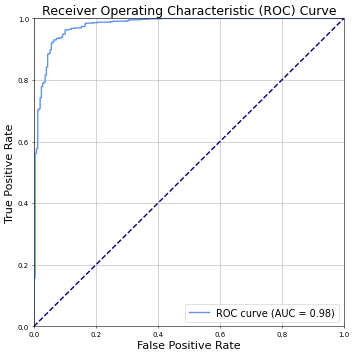

DenseNet: 


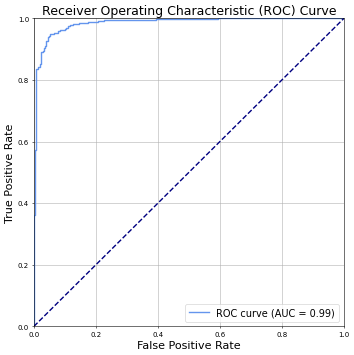

In [35]:
print('CNN: ')
plot_roc_curve(test_df['label'], y_pred_cnn)
print("DenseNet: ")
plot_roc_curve(test_df['label'], y_pred_denseNet)

### 8. Train a CNN for a multi-class prediction (bacteria, virus, none)
- Adapt a CNN (e.g. pick one form 5. or 6.) and modify it to predict if a patient has a bacterial or a virus infection, or none of both using the `infection_type` column as label.
- This requires to also adapt the generators.

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images
image_generator = ImageDataGenerator(
    rescale=1.0/255
)

# Pick your label column(s)
label_column = ['none', 'virus', 'bacteria'] # add the label-columns we want to predict

# Define the data generators
multi_class_train_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col="filepath",
    y_col=label_column,
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="rgb" # add color mode
)

multi_class_val_generator = image_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=path,
    x_col="filepath",
    y_col=label_column,
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="rgb", #add color mode,
    shuffle=False,  # this is crucial for later evaluation!
)

multi_class_test_generator = image_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=path,
    x_col="filepath",
    y_col=label_column,
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="rgb", #add color mode,
    shuffle=False,  # this is crucial for later evaluation!
)

Found 4071 validated image filenames.
Found 892 validated image filenames.
Found 893 validated image filenames.


In [37]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 model but exclude the top layer (classification layer)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

# Add your own top layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(label_column), activation="softmax")(x) # use softmax activation for multi class prediction

# Create the actual model
multi_class_model = Model(inputs=base_model.input, outputs=predictions)
multi_class_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 326, 326, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

#### class weights

In [38]:
# Calculate class weights
class_weights = train_df[label_column].sum(axis=0)
print(class_weights)
class_weights = class_weights.sum() / class_weights 
print(class_weights)

# Ensure class weights sum up to 1
class_weights = class_weights / class_weights.sum()
print(class_weights)

from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

def weighted_binary_crossentropy(class_weights):
    class_weights = tf.constant([class_weights[k] for k in sorted(class_weights.keys())], dtype=tf.float32)  # ensure class_weights is float32

    def _weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)  # ensure y_true is float32
        y_pred = tf.cast(y_pred, tf.float32)  # ensure y_pred is float32
        crossentropy = binary_crossentropy(y_true, y_pred)
        weight_vector = tf.reduce_sum(class_weights * y_true, axis=-1)
        weighted_loss = weight_vector * crossentropy
        return tf.reduce_mean(weighted_loss)

    return _weighted_binary_crossentropy

none        1101
virus       1032
bacteria    1938
dtype: int64
none        3.697548
virus       3.944767
bacteria    2.100619
dtype: float64
none        0.379511
virus       0.404885
bacteria    0.215604
dtype: float64


In [39]:
for layer in base_model.layers:
    layer.trainable = False

# Compile the new model
multi_class_model.compile(optimizer='adam',
              loss=weighted_binary_crossentropy(class_weights),
              metrics="accuracy")

In [40]:
# save model checkpoints
multi_class_path = "shared_folder/model_checkpoints/multi-class.ckpt"

# Create a callback that saves the model's weights
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=multi_class_path,
                                                 save_weights_only=True,    # saving only the weights, because we have the architecture of the model
                                                 verbose=1, 
                                                 monitor='val_accuracy',    # we are monitoring the accuracy on the validation set
                                                 mode='max',                # the greatest accuracy on the validation is the best outcome
                                                 save_best_only=True)       # we only want to save the best model. The other chechpoints are not interesting to us

# Train the model
history = multi_class_model.fit(
    multi_class_train_generator,
    epochs=100,
    validation_data=multi_class_val_generator,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],  # Pass callback to training
)

Epoch 1/100


2023-07-08 10:47:40.336187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


128/128 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.7224

2023-07-08 10:48:30.315144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.79372, saving model to shared_folder/model_checkpoints/multi-class.ckpt
128/128 [==============================] - 63s 448ms/step - loss: 0.1409 - accuracy: 0.7224 - val_loss: 0.1242 - val_accuracy: 0.7937
Epoch 2/100
128/128 [==============================] - ETA: 0s - loss: 0.1199 - accuracy: 0.7863
Epoch 2: val_accuracy improved from 0.79372 to 0.80830, saving model to shared_folder/model_checkpoints/multi-class.ckpt
128/128 [==============================] - 58s 454ms/step - loss: 0.1199 - accuracy: 0.7863 - val_loss: 0.1153 - val_accuracy: 0.8083
Epoch 3/100
128/128 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.7969
Epoch 3: val_accuracy improved from 0.80830 to 0.80942, saving model to shared_folder/model_checkpoints/multi-class.ckpt
128/128 [==============================] - 59s 462ms/step - loss: 0.1145 - accuracy: 0.7969 - val_loss: 0.1118 - val_accuracy: 0.8094
Epoch 4/100
127/128 [======================

### 9. Evaluate the multi-class model
- Evaluate the multi-class prediction model, simliar to what you did in (7.). Again also include a ROC curve (now of course for all 3 possible labels).
- Is the performance comparable, better, worse than the pneumonia/no pneumonia case?
- Which label can be predicted with the highest precision?

In [41]:
# Code for multi-class model
from sklearn.metrics import roc_curve, auc
def plot_multi_class_ROC(labels, predicted_labels):
    # Compute the ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    classes = label_column

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], predicted_labels[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(8, 8))

    # Get class names
    class_names = list(classes)

    for i, label in enumerate(classes):
        ax.plot(fpr[i], tpr[i],
                label=f"ROC curve -> {label} (area = {roc_auc[i]:.2f})")

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc="lower right")
    plt.grid(True)
    plt.show()

2023-07-08 11:08:16.815719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


28/28 [==============================] - 12s 399ms/step


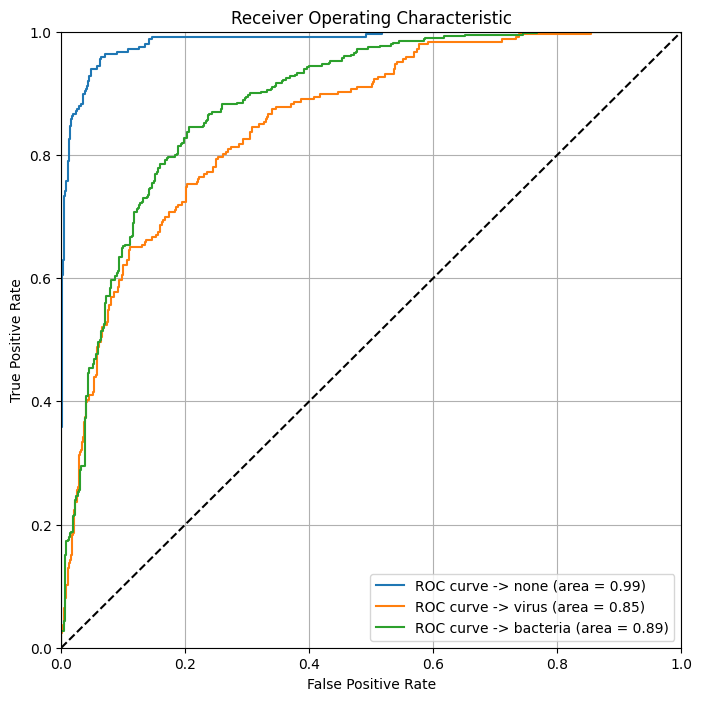

In [47]:
y_pred_multi_class = multi_class_model.predict(multi_class_test_generator)
y_true_multi_class = multi_class_test_generator.labels

plot_multi_class_ROC(y_true_multi_class, y_pred_multi_class)

### 10.1 Possible improvements
Try two possible strategies to improve the results you got on 8. and 9.
1. Data augmentation.

In [42]:
# Normalize images
augmented_image_generator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=7, #random rotation of image by x degrees
    zoom_range=0.15,
    shear_range=1.5 # shear intensity. (Shear angle in counter-clockwise direction in degrees)
)

In [43]:
# Pick your label column(s)
label_column = ['none', 'virus', 'bacteria'] # add the label-columns we want to predict

# Define the data generators
augmented_multi_class_train_generator = augmented_image_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col="filepath",
    y_col=label_column,
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="rgb" # add color mode
)

Found 4071 validated image filenames.


In [44]:
# Load the DenseNet121 model but exclude the top layer (classification layer)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

# Add your own top layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(label_column), activation="softmax")(x) # use softmax activation for multi class prediction

# Create the actual model
augmented_multi_class_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Compile the new model
augmented_multi_class_model.compile(optimizer='adam',
              loss=weighted_binary_crossentropy(class_weights),
              metrics="accuracy")

# save model checkpoints
augmented_multi_class_path = "shared_folder/model_checkpoints/augmented_multi-class.ckpt"

# Create a callback that saves the model's weights
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=augmented_multi_class_path,
                                                 save_weights_only=True,    # saving only the weights, because we have the architecture of the model
                                                 verbose=1, 
                                                 monitor='val_accuracy',    # we are monitoring the accuracy on the validation set
                                                 mode='max',                # the greatest accuracy on the validation is the best outcome
                                                 save_best_only=True)       # we only want to save the best model. The other chechpoints are not interesting to us

# Train the model
history = augmented_multi_class_model.fit(
    augmented_multi_class_train_generator,
    epochs=100,
    validation_data=multi_class_val_generator,  # we can use the same validation generator again. The validation data does not need to be updated.
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],  # Pass callback to training
)

Epoch 1/100


2023-07-08 10:57:10.067900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


128/128 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.6817

2023-07-08 10:58:53.354456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.79260, saving model to shared_folder/model_checkpoints/augmented_multi-class.ckpt
128/128 [==============================] - 117s 870ms/step - loss: 0.1558 - accuracy: 0.6817 - val_loss: 0.1238 - val_accuracy: 0.7926
Epoch 2/100
128/128 [==============================] - ETA: 0s - loss: 0.1303 - accuracy: 0.7696
Epoch 2: val_accuracy did not improve from 0.79260
128/128 [==============================] - 107s 837ms/step - loss: 0.1303 - accuracy: 0.7696 - val_loss: 0.1346 - val_accuracy: 0.7735
Epoch 3/100
128/128 [==============================] - ETA: 0s - loss: 0.1258 - accuracy: 0.7752
Epoch 3: val_accuracy improved from 0.79260 to 0.81502, saving model to shared_folder/model_checkpoints/augmented_multi-class.ckpt
128/128 [==============================] - 107s 834ms/step - loss: 0.1258 - accuracy: 0.7752 - val_loss: 0.1142 - val_accuracy: 0.8150
Epoch 4/100
128/128 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 

### 10.2 Possible improvements
Try two possible strategies to improve the results you got on 8. and 9.  
1. ~~Data Augmentation~~
2. Model fine tuning. This refers to the training of a large network with lower learning rate, but with more layers of the base model being set to `trainable`.
We haven't done this before, so here some example code of how to "unfreeze" some layers and make them trainable again:
```python
# Now: unfreeze some of the base model layers and do a second pass of training
for layer in model.layers[:100]:
    layer.trainable = False
for layer in model.layers[100:]:
    layer.trainable = True
``` 

In [49]:
fine_tuned_otimizer = Adam(learning_rate=1e-5)

In [50]:
# Load the DenseNet121 model but exclude the top layer (classification layer)
fine_tuned_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

# Add your own top layer for classification
x = fine_tuned_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(label_column), activation="softmax")(x) # use softmax activation for multi class prediction

# Create the actual model
fine_tuned_multi_class_model = Model(inputs=fine_tuned_base_model.input, outputs=predictions)

In [51]:

# Now: unfreeze some of the base model layers and do a second pass of training
for layer in fine_tuned_base_model.layers[:100]:
    layer.trainable = False
for layer in fine_tuned_base_model.layers[100:]:
    layer.trainable = True

In [52]:
# use lower learning rate on Adam optimizer
from tensorflow.keras.optimizers import Adam
fine_tuned_optimizer = Adam(learning_rate=1e-5)

In [53]:
# Compile the new model
fine_tuned_multi_class_model.compile(optimizer=fine_tuned_optimizer,
              loss=weighted_binary_crossentropy(class_weights),
              metrics="accuracy")

# save model checkpoints
fine_tuned_multi_class_path = "shared_folder/model_checkpoints/fine_tuned_multi-class.ckpt"

# Create a callback that saves the model's weights
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=fine_tuned_multi_class_path,
                                                 save_weights_only=True,    # saving only the weights, because we have the architecture of the model
                                                 verbose=1, 
                                                 monitor='val_accuracy',    # we are monitoring the accuracy on the validation set
                                                 mode='max',                # the greatest accuracy on the validation is the best outcome
                                                 save_best_only=True)       # we only want to save the best model. The other chechpoints are not interesting to us

# Train the model
history = fine_tuned_multi_class_model.fit(
    augmented_multi_class_train_generator,
    epochs=100,
    validation_data=multi_class_val_generator,  # we can use the same validation generator again. The validation data does not need to be updated.
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],  # Pass callback to training
)

Epoch 1/100


2023-07-08 11:35:01.104823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


128/128 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.6721

2023-07-08 11:39:57.130039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.79148, saving model to shared_folder/model_checkpoints/fine_tuned_multi-class.ckpt
128/128 [==============================] - 311s 2s/step - loss: 0.1829 - accuracy: 0.6721 - val_loss: 0.1577 - val_accuracy: 0.7915
Epoch 2/100
128/128 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.7885
Epoch 2: val_accuracy improved from 0.79148 to 0.81278, saving model to shared_folder/model_checkpoints/fine_tuned_multi-class.ckpt
128/128 [==============================] - 198s 2s/step - loss: 0.1328 - accuracy: 0.7885 - val_loss: 0.1299 - val_accuracy: 0.8128
Epoch 3/100
128/128 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.8015
Epoch 3: val_accuracy improved from 0.81278 to 0.83072, saving model to shared_folder/model_checkpoints/fine_tuned_multi-class.ckpt
128/128 [==============================] - 174s 1s/step - loss: 0.1194 - accuracy: 0.8015 - val_loss: 0.1137 - val_accuracy: 0.8307
Epoch 4/100
128/

### 10.3 Possible improvements
You can still use the `Adam` optimizer, but preferably with a much lower learning rate, maybe `1e-5`.
- Do you see any promising effect of one or both of those strategies?

2023-07-08 11:58:35.415584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


28/28 [==============================] - 24s 869ms/step


2023-07-08 11:59:00.862992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


28/28 [==============================] - 25s 850ms/step
Augmented model: 


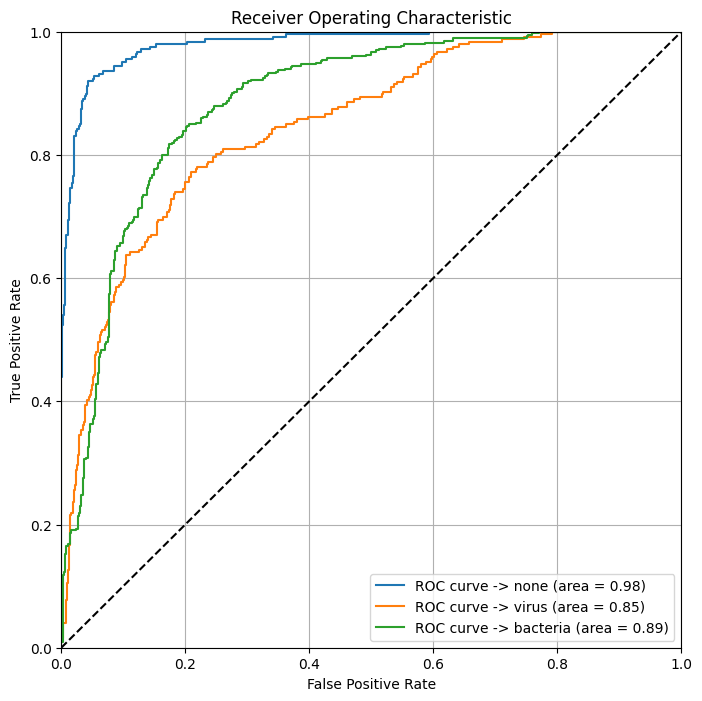

Fine tuned model:


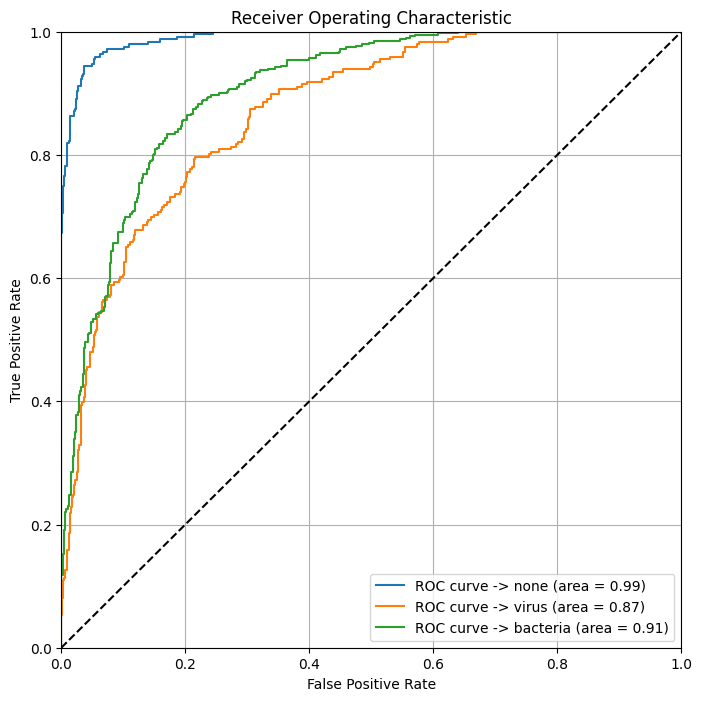

In [54]:
y_pred_augmented_multi_class = augmented_multi_class_model.predict(multi_class_test_generator)
y_pred_fine_tuned_multi_class = fine_tuned_multi_class_model.predict(multi_class_test_generator)
y_true_multi_class = multi_class_test_generator.labels

print('Augmented model: ')
plot_multi_class_ROC(y_true_multi_class, y_pred_augmented_multi_class)
print('Fine tuned model:')
plot_multi_class_ROC(y_true_multi_class, y_pred_fine_tuned_multi_class)

## Final submission:
Please address all the above mentioned points in this notebook (e.g., using text cells where needed for explanations or answers). Obviously, you can use code snippets from notebooks we have already worked on during the live coding sessions.


### Happy hacking!!!